In [1]:
import os
import numpy as np
#from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import cv2
#from sklearn.preprocessing import StandardScaler

In [2]:
#Configurações usadas no código

IMG_SIZE = (64, 64)  #padrão: (128, 128)

#Categorias servirá para atribuir labels às fotos
CATEGORIAS = { 
    "0-12_infantil": 0,
    "13-17_adolescente": 1,
    "18-64_adulto": 2,
    "65+_idoso": 3
}

#Categorias_resumidas servirá para impressão da predição, no fim do código
CATEGORIAS_RESUMIDAS = {
    "0-12_infantil": 'Criança',
    "13-17_adolescente": 'Adolescente',
    "18-64_adulto": 'Adulto',
    "65+_idoso": 'Idoso'
}

In [3]:
#Caminho das pastas das fotos
BASE_DIR = "dados_teste_full/"

In [35]:
#Função que aplica o filtro nas fotos
def realca_borda(img, img_size):
    #Redimensionar e tonar preto e bracnco
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #Suavização
    img = cv2.GaussianBlur(img, (3, 3), 0) #3,3

    #Contraste
    img = cv2.equalizeHist(img)

    # Detecção de bordas
    #img = cv2.Canny(img, 125, 175)

    return img

In [36]:
#Reconstrução da imagema através da redução feita pelo PCA
def reconstroi_imagem(autov, img, img_size):
    imagem_aprox = img @ autov.T
    mostra_imagem(np.reshape(imagem_aprox, img_size))

In [37]:
#Imprimir a imagem na tela
def mostra_imagem(img):
    plt.imshow(img, cmap='gray') 
    plt.axis('off')  #Remove os eixos
    plt.show()

In [38]:
#Grava cada imagem na matriz, aplicando filtros e linearizando as imagens
def carregar_dados(base_dir, categorias, img_size):
    imagens = []
    labels = []
    for categoria, label in categorias.items():
        pasta = os.path.join(base_dir, categoria)
        for arquivo in os.listdir(pasta):
            caminho_imagem = os.path.join(pasta, arquivo)
            try:
                # Carregar imagem, converter para escala de cinza e redimensionar
                img = realca_borda(cv2.imread(caminho_imagem), IMG_SIZE) #Image.open(caminho_imagem).convert('L').resize(img_size)
                imagens.append(np.array(img).flatten())  # Achatar a imagem em um vetor
                labels.append(label)
            except Exception as e:
                print(f"Erro ao carregar imagem {caminho_imagem}: {e}")
    return np.array(imagens), np.array(labels)

In [45]:
#carregar imagens na matriz e normalização
imagens, labels = carregar_dados(BASE_DIR, CATEGORIAS, IMG_SIZE)
imagens = imagens / 255.0

In [46]:
np.shape(imagens)

(16627, 4096)

In [47]:
#scaler = StandardScaler()
#imagens = scaler.fit_transform(imagens)

In [48]:
img = imagens[5,:]

In [49]:
img = np.reshape(img, IMG_SIZE)

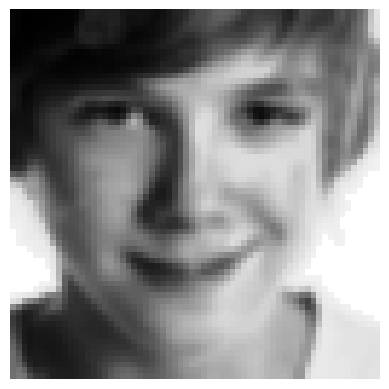

In [50]:
mostra_imagem(img)

In [51]:
#Separação dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(imagens, labels, test_size=0.25, random_state=42, stratify=labels)

In [52]:
#mostra_imagem(np.reshape(X_test[500,:], (128,128)))

In [53]:
#redução dos dados de forma a manter 98% da variância
pca = PCA(n_components=0.98)  # 0.95 padrão
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
autovetores = pca.components_.T

In [54]:
print(np.shape(X_train))
print(np.shape(X_train_pca))
print(np.shape(autovetores))

(12470, 4096)
(12470, 316)
(4096, 316)


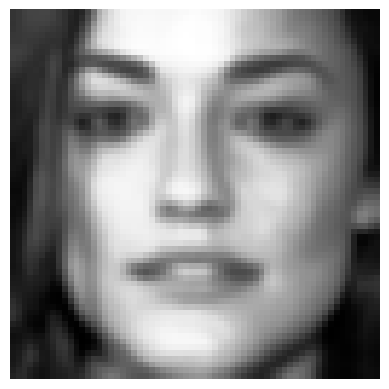

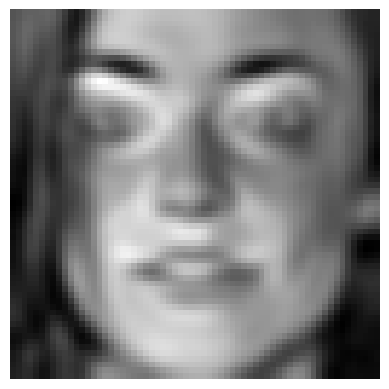

In [56]:
#mostras as imagens reconstruídas

matriz_aprox = X_train_pca @ autovetores.T
mostra_imagem(np.reshape(X_train[657,:], IMG_SIZE))
mostra_imagem(np.reshape(matriz_aprox[657,:], IMG_SIZE))

In [18]:
#treina o modelo utilizando regressão logística
modelo = LogisticRegression(solver='lbfgs', max_iter=1000) #1000 padrao
modelo.fit(X_train_pca, y_train)

LogisticRegression(max_iter=1000)

In [19]:
#testando o modelo com os dados separados para teste
y_pred = modelo.predict(X_test_pca)
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=CATEGORIAS.keys()))

Relatório de Classificação:
                   precision    recall  f1-score   support

    0-12_infantil       0.83      0.82      0.83       853
13-17_adolescente       0.28      0.08      0.12       205
     18-64_adulto       0.83      0.92      0.87      2612
        65+_idoso       0.68      0.51      0.58       487

         accuracy                           0.81      4157
        macro avg       0.65      0.58      0.60      4157
     weighted avg       0.78      0.81      0.79      4157



In [20]:
#mostra a matriz de confusão
print(confusion_matrix(y_test, y_pred))

[[ 702   19  126    6]
 [  38   16  149    2]
 [  93   19 2390  110]
 [  11    4  225  247]]


In [23]:
#Precisão geral do método
print(accuracy_score(y_test, y_pred))

0.8070724079865288


In [24]:
#Predição de uma nova imagem
def prever_imagem(caminho_imagem, modelo, pca, img_size):
    img = realca_borda(cv2.imread(caminho_imagem), img_size) #Image.open(caminho_imagem).convert('L').resize(img_size)
    mostra_imagem(img)
    img_vetor = np.array(img).flatten().reshape(1, -1)
    img_vetor = img_vetor / 255.0
    img_pca = pca.transform(img_vetor)
    reconstroi_imagem(img_pca, autovetores, img_size)
    predicao = modelo.predict(img_pca)[0]
    for categoria, label in CATEGORIAS.items():
        if label == predicao:
            return categoria

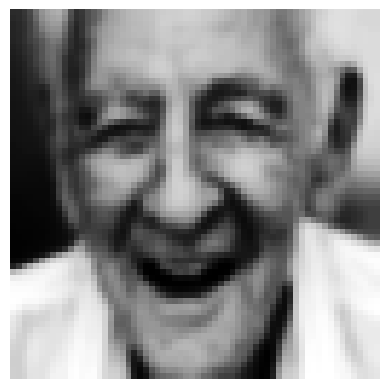

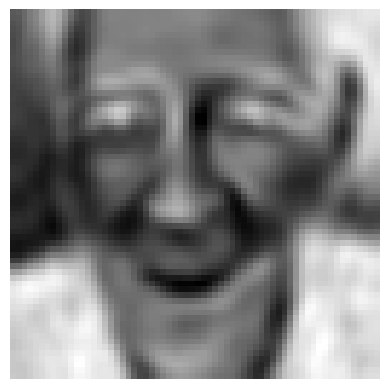

A imagem pertence à categoria: Idoso


In [69]:
#Resultados
caminho_teste = "testes/idoso1.png"
categoria_prevista = prever_imagem(caminho_teste, modelo, pca, IMG_SIZE)
print(f"A imagem pertence à categoria: {CATEGORIAS_RESUMIDAS[categoria_prevista]}")